In [1]:
import numpy as np
import math
from fractions import Fraction
import itertools
from biotuner_utils import *
from biotuner_offline import *
import matplotlib.pyplot as plt
from numpy import array, zeros, ones, arange, log2, sqrt, diff, concatenate
import emd
from PyEMD import EMD, EEMD
from scipy.signal import butter, lfilter
import colorednoise as cn
from biotuner import *
import mne

## Load dataset

In [4]:

path = 'D:/Science/EEG_data/'
#path = 'C:/Users/Dell/GitHub/CoCoBrainChannel/'
epochs = mne.read_epochs(path+'pareidolia_run2.fif')
#epochs = mne.read_epochs('C:/Users/Antoine/github/Data_EEG/pareidolia_run1.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

Reading D:/Science/EEG_data/pareidolia_run2.fif ...
    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available


<ipython-input-4-3a5d2e6fe601>:3: RuntimeWarning: This filename (D:/Science/EEG_data/pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path+'pareidolia_run2.fif')


Not setting metadata
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)


## Initialize biotuner object and methods

In [80]:
class biotuner(object):
    
    '''Class used to derive peaks information, musical scales and related metrics from time series  
    
    Example of use:       
    biotuning = biotuner(sf = 1000)
    biotuning.peaks_extraction(data)
    biotuning.peaks_extension()
    biotuning.peaks_metrics()
    '''
    
    def __init__(self, sf, peaks_function = 'EEMD', precision = 0.2, compute_sub_ratios = False, 
                 n_harm = 10, harm_function = 'mult', extension_method = 'consonant_harmonic_fit',
                 ratios_harms = False, ratios_inc = False, ratios_inc_fit = False, ratios_n_harms = 5):
        '''Initializing sampling frequency'''
        self.sf = sf
        '''Initializing arguments for peak extraction
           peaks_function: method used to extract the peaks ['EEMD', 'EMD', 'HH1D_max', 'adapt', 'fixed']
           precision: precision of the peaks in Hz
           compute_sub_ratios: when set to True, include ratios < 1 in peaks_ratios attribute [True, False]'''
        self.peaks_function = peaks_function
        self.precision = precision
        self.compute_sub_ratios = compute_sub_ratios
        '''Initializing arguments for peaks metrics
           n_harm: number of harmonics to compute in harmonic_fit function
           harm_function: compute harmonics from iterative multiplication (x, 2x, 3x, ...nx) or division (x, x/2, x/3, ...x/n) ['mult', 'div']
           extension_method: ['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']'''
        self.n_harm = n_harm
        self.harm_function = harm_function
        self.extension_method = extension_method
        '''Initializing dictionary for scales metrics'''
        self.scale_metrics = {}
        '''Initializing arguments for ratios extension'''
        self.ratios_harms = ratios_harms
        self.ratios_inc = ratios_inc
        self.ratios_inc_fit = ratios_inc_fit
        self.ratios_n_harms = ratios_n_harms
    
    
    '''First method to use. Requires data as input argument
       Generates self.peaks and self.peaks_ratios attributes'''

    def peaks_extraction (self, data, peaks_function = None, FREQ_BANDS = None, precision = None, sf = None, max_freq = 80, 
                          compute_sub_ratios = None, ratios_extension = False):
        
        
        self.data = data
        if sf == None:
            sf = self.sf
        if precision == None:
            precision = self.precision
        if peaks_function == None:
            peaks_function = self.peaks_function
        if compute_sub_ratios == None:
            compute_sub_ratios = self.compute_sub_ratios
        self.peaks, self.amps = self.compute_peaks_ts (data, peaks_function = peaks_function, FREQ_BANDS = None, precision = precision, sf = sf, max_freq = max_freq)

        self.peaks_ratios = compute_peak_ratios(self.peaks, rebound = True, octave = 2, sub = compute_sub_ratios)
        if ratios_extension == True:
            a, b, c = self.ratios_extension(self.extended_peaks_ratios)
            if a != None:
                self.peaks_ratios_harms = a
            if b != None:
                self.peaks_ratios_inc = b
            if c != None:
                self.peaks_ratios_inc_fit = c
    '''Generates self.extended_peaks and self.extended_peaks_ratios attributes'''
    
    def peaks_extension (self, peaks = None, n_harm = None, method = None, harm_function = 'mult', cons_limit = 0.1, 
                         ratios_extension = False):
        if peaks == None:
            peaks = self.peaks
        if n_harm == None:
            n_harm = self.n_harm
        if method == None:
            method = self.extension_method
        if method == 'harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function, div_mode = 'div')
            self.extended_peaks = np.sort(list(self.peaks)+list(extended_peaks))
        if method == 'consonant':
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(cons_peaks, 3))
        if method == 'multi_consonant':
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(multi_consonance(cons_pairs, n_freqs = 10), 3))
        if method == 'consonant_harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function, div_mode = 'div_add')
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (extended_peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(cons_peaks, 3))
        if method == 'multi_consonant_harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function)
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (extended_peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(multi_consonance(cons_pairs, n_freqs = 10), 3))
        self.extended_peaks = [i for i in self.extended_peaks if i<self.sf/2]
        self.extended_amps = peaks_to_amps(self.extended_peaks, self.freqs, self.psd, self.sf)
        self.extended_peaks_ratios = compute_peak_ratios(self.extended_peaks, rebound = True)
        if ratios_extension == True:
            a, b, c = self.ratios_extension(self.extended_peaks_ratios)
            if a != None:
                self.extended_peaks_ratios_harms = a
            if b != None:
                self.extended_peaks_ratios_inc = b
            if c != None:
                self.extended_peaks_ratios_inc_fit = c
    
    def ratios_extension (self, ratios, ratio_fit_bounds = 0.001):
        if self.ratios_harms == True:
            ratios_harms_ = ratios_harmonics(ratios, self.ratios_n_harms)
        else: 
            ratios_harms_ = None
        if self.ratios_inc == True:
            ratios_inc_ = ratios_increments(ratios, self.ratios_n_harms)
        else: 
            ratios_inc_ = None
        if self.ratios_inc_fit == True:
            ratios_inc_fit_ = harmonic_fit(ratios, self.ratios_n_harms, function = 'exp', bounds = ratio_fit_bounds)
        else: 
            ratios_inc_fit_ = None
        return ratios_harms_, ratios_inc_, ratios_inc_fit_
    
    def compute_spectromorph (self, IMFs = None, sf = None, method = 'SpectralCentroid', window = None, overlap = 1, comp_chords = False, min_notes = 3, 
                              cons_limit = 0.2, cons_chord_method = 'cons'):
        if IMFs == None:
            try:
                IMFs = self.IMFs
            except:
                IMFs = EMD_eeg(self.data)[1:6]
                self.IMFs = IMFs
                
        if sf == None:
            sf = self.sf
        if window == None:
            window = int(sf/2)
            
        spectro_EMD = EMD_to_spectromorph(IMFs, 1000, method = method, window = window, overlap = overlap)
        self.spectro_EMD = np.round(spectro_EMD, 1)
        if method == 'SpectralCentroid':
            self.SpectralCentroid = self.spectro_EMD
        if method == 'SpectralFlux':
            self.SpectralFlux = self.spectro_EMD
        if comp_chords == True:
            self.spectro_chords = timepoint_consonance(self.spectro_EMD, method = cons_chord_method, limit = cons_limit, min_notes = min_notes)  
            
    def compute_peaks_metrics (self, n_harm = None):
        if n_harm == None:
            n_harm = self.n_harm
            
        peaks = list(self.peaks)
        metrics = {'cons' : 0, 'euler' : 0, 'tenney': 0, 'harm_fit': 0}   
        metrics['harm_fit'] = len(harmonic_fit(peaks, n_harm = n_harm))
        a, b, c, metrics['cons'] = consonance_peaks (peaks, 0.1)
        peaks_euler = [int(round(num, 2)*1000) for num in peaks]
        metrics['euler'] = euler(*peaks_euler)
        metrics['tenney'] = tenneyHeight(peaks)
        metrics_list = []
        for value in metrics.values():
            metrics_list.append(value)
        self.peaks_metrics_list = metrics_list
        self.peaks_metrics = metrics

    '''Methods to compute scales from whether peaks or extended peaks'''
    
    def compute_diss_curve (self, input_type = 'peaks', denom=1000, max_ratio=2, consonance = True, method = 'min', plot = False, n_tet_grid = 12):
        if input_type == 'peaks':
            peaks = self.peaks
            amps = self.amps
        if input_type == 'extended_peaks':
            peaks = self.extended_peaks
            amps = self.extended_amps

        peaks = [p*128 for p in peaks]
        amps = np.interp(amps, (np.array(amps).min(), np.array(amps).max()), (0.2, 0.8))
        
        intervals, self.diss_scale, euler_diss, diss, harm_sim_diss = diss_curve (peaks, amps, denom=denom, max_ratio=max_ratio, consonance = consonance, method = method, plot = plot, n_tet_grid = n_tet_grid)
        self.scale_metrics['diss_euler'] = euler_diss
        self.scale_metrics['dissonance'] = diss
        self.scale_metrics['diss_harm_sim'] = np.average(harm_sim_diss)
        self.scale_metrics['diss_n_steps'] = len(self.diss_scale)
        
    def compute_harmonic_entropy(self, input_type = 'peaks', res = 0.001, spread = 0.01, plot_entropy = True, plot_tenney = False, octave = 2, rebound = True, sub = False):
        if input_type == 'peaks':
            ratios = compute_peak_ratios(self.peaks, rebound = False, sub = False)
        if input_type == 'extended_peaks':
            ratios = compute_peak_ratios(self.extended_peaks, rebound = rebound, sub = sub)
        if input_type == 'extended_peaks_harms':
            ratios = self.extended_peaks_ratios_harms
        if input_type == 'extended_peaks_inc':
            ratios = self.extended_peaks_ratios_inc
        if input_type == 'extended_peaks_inc_fit':
            ratios = self.extended_peaks_ratios_inc_fit
            
        HE_scale, HE = harmonic_entropy(ratios, res = res, spread = spread, plot_entropy = plot_entropy, plot_tenney = plot_tenney, octave = octave)
        self.HE_scale = HE_scale[0]
        self.scale_metrics['HE'] = HE
        self.scale_metrics['HE_n_steps'] = len(self.HE_scale)  
        self.scale_metrics['HE_harm_sim'] = np.average(ratios2harmsim(list(biotuning.HE_scale)))
        '''
        ratios_euler = [a]+ratios
        ratios_euler = [int(round(num, 2)*1000) for num in ratios]
        euler_score = None
        if consonance == True:
            euler_score = euler(*ratios_euler)
            euler_score = euler_score/len(diss_minima)
        '''
    
    
    
    
    '''Methods called by the peaks_extraction method'''
    
    def compute_peak(self, eeg_data, sf=1000, nperseg = 0, nfft = 0, precision = 0.25, average = 'median'):
        if nperseg == 0:
            mult = 1/precision
            nperseg = sf*mult
            nfft = nperseg
        import scipy
        freqs, psd = scipy.signal.welch(eeg_data, sf, nfft = nfft, nperseg = nperseg, average = average)
        self.freqs = freqs
        self.psd = psd
        psd = 10. * np.log10(psd) 
        bin_size = (sf/2)/len(freqs)
        #min_index = int(minf/bin_size)
        #max_index = int(maxf/bin_size)
        index_max = np.argmax(np.array(psd))
        FREQS = np.array(freqs[index_max])
        amps = np.array(psd[index_max])

        return FREQS, amps
    
    def compute_peaks_raw(self, eeg_data, FREQ_BANDS, sf=1000, nperseg = 0, nfft = 0, precision=0.25, average = 'median'):
        if nperseg == 0:
            mult = 1/precision
            nperseg = sf*mult
            nfft = nperseg
        import scipy
        psd_all = []
        freqs_all = []
        FREQs_temp= []
        amp_temp = []

        for minf, maxf in FREQ_BANDS:
            freqs, psd = scipy.signal.welch(eeg_data, sf, nfft = nfft, nperseg = nperseg, average = average)
            self.freqs = freqs
            psd = 10. * np.log10(psd)
            self.psd = psd
            bin_size = (sf/2)/len(freqs)
            self.bin_size = bin_size
            min_index = int(minf/bin_size)
            max_index = int(maxf/bin_size)
            index_max = np.argmax(np.array(psd[min_index:max_index]))
             #   print(index_max) # Should not be zero in all bands (would signify strong 1/f trend)
            FREQs_temp.append(freqs[min_index+index_max])
            amp_temp.append(psd[min_index+index_max])

        FREQS = np.array(FREQs_temp)
        amps = np.array(amp_temp)
        return FREQS, amps
    
    def compute_peaks_ts (self, data, peaks_function = 'EMD', FREQ_BANDS = None, precision = 0.25, sf = 1000, max_freq = 80):
        alphaband = [[7, 12]]
        try:
            if FREQ_BANDS == None:
                FREQ_BANDS = [[2, 3.55], [3.55, 7.15], [7.15, 14.3], [14.3, 28.55], [28.55, 49.4]]
        except:
            pass
        if peaks_function == 'EEMD':
            IMFs = EMD_eeg(data)[1:6]
            self.IMFs = IMFs
        if peaks_function == 'EMD':
            data = np.interp(data, (data.min(), data.max()), (0, +1))
            IMFs = emd.sift.sift(data)
            #IMFs = emd.sift.ensemble_sift(data)
            IMFs = np.moveaxis(IMFs, 0, 1)[1:6]
            self.IMFs = IMFs
        try:
            peaks_temp = []
            amps_temp = []
            for imf in range(len(IMFs)):
                p, a = self.compute_peak(IMFs[imf], precision = precision, average = 'median')
                peaks_temp.append(p)

                amps_temp.append(a)

            peaks_temp = np.flip(peaks_temp)
            amps_temp = np.flip(amps_temp)
        except:
            pass
        if peaks_function == 'HH1D_max':
            IMFs = EMD_eeg(data)
            IMFs = np.moveaxis(IMFs, 0, 1)
            IP, IF, IA = emd.spectra.frequency_transform(IMFs[:, 1:6], sf, 'nht')
            precision_hh = precision*2
            low = 1
            high = max_freq
            steps = int((high-low)/precision_hh)
            edges, bins = emd.spectra.define_hist_bins(low, high, steps, 'log')
            self.IF = np.moveaxis(IF, 0 ,1)
            # Compute the 1d Hilbert-Huang transform (power over carrier frequency)
            spec = emd.spectra.hilberthuang_1d(IF, IA, edges)
            
            spec = np.moveaxis(spec, 0, 1)
            peaks_temp = []
            amps_temp = []
            for e, i in enumerate(spec):
                max_power = np.argmax(i)
                peaks_temp.append(bins[max_power])
                amps_temp.append(spec[e][max_power])
            peaks_temp = np.flip(peaks_temp)
            amps_temp = np.flip(amps_temp)
        #if peaks_function == 'HH1D_weightAVG':

        if peaks_function == 'adapt':
            p, a = self.compute_peaks_raw(data, alphaband, precision = precision, average = 'median')
            FREQ_BANDS = alpha2bands(p)
            peaks_temp, amps_temp = self.compute_peaks_raw(data, FREQ_BANDS, precision = precision, average = 'median')
        if peaks_function == 'fixed':
            peaks_temp, amps_temp = self.compute_peaks_raw(data, FREQ_BANDS, precision = precision, average = 'median')
        peaks = np.array(peaks_temp)
        amps = np.array(amps_temp)
        return peaks, amps
    
    
    '''Generic method to fit all Biotuner methods'''
    
    def fit_all(self, data, compute_diss = True, compute_HE = True, compute_peaks_extension = True):
        biotuning = biotuner(self.sf, peaks_function = self.peaks_function, precision = self.precision, n_harm = self.n_harm)
        biotuning.peaks_extraction(data)
        biotuning.compute_peaks_metrics()
        if compute_diss == True:
            biotuning.compute_diss_curve(input_type = 'peaks', plot = False)
        if compute_peaks_extension == True:
            biotuning.peaks_extension(method = 'multi_consonant_harmonic_fit', harm_function = 'mult', cons_limit = 0.01)
        if compute_HE == True:
            biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', plot_entropy = False)
        return biotuning
    
    def info(self, metrics=False, scales=False, whatever=False):
        if metrics == True:
            print('METRICS')
            print(vars(self))
        
        else:
            print(vars(self))
        return

In [93]:
for enumerate(p) in biotuning.peaks:
    print(p)

SyntaxError: cannot assign to function call (<ipython-input-93-f0735df0f1d0>, line 1)

In [ ]:
incut = 1
outcut = 3
biotuning.IMFs[0][incut:outcut]

(5, 21)
(5, 21)
(168, 6)


C:\Users\Antoine\github\biotuner\biotuner.py:146: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  harm_fit = np.array(harm_temp).squeeze()


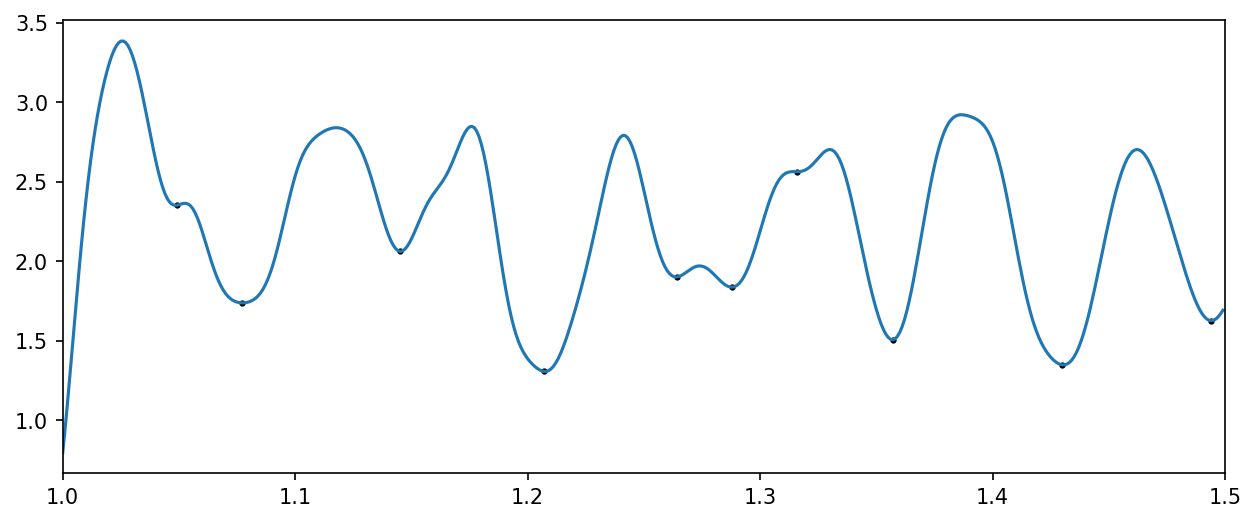

1.4570493698120117


In [87]:
import time
start = time.time()
data = epochs_data[15][55][0:6000] # Define data (single time series)
biotuning = biotuner(1000, peaks_function = 'EEMD', precision = 0.5, n_harm = 20,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object
biotuning.peaks_extraction(data)
biotuning.compute_peaks_metrics()
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult', cons_limit = 0.1, ratios_extension = True)
#biotuning.compute_diss_curve(plot = False, input_type = 'peaks', denom = 50, consonance = False, n_tet_grid = 12)
biotuning.compute_spectromorph(comp_chords = True, min_notes = 5, cons_limit = 50, cons_chord_method = 'euler')

biotuning.compute_harmonic_entropy(input_type = 'extended_peaks_inc_fit', plot_entropy = True, octave = 1.5, rebound = True)
stop = time.time()
print(stop-start)

In [91]:
biotuning.SpectralCentroid.shape

(5, 5000)

In [85]:
#IF = np.moveaxis(biotuning.IF, 0 ,1)
plt.plot(biotuning.IF[4][10:-10])

AttributeError: 'biotuner' object has no attribute 'IF'

In [27]:
np.var(biotuning.IF[4][10:-10])

2.7431259163322874

In [29]:
a = biotuning.spectro_chords[0]
b = biotuning.spectro_chords[1]
a


[60.5, 28.6, 13.2, 7.2, 4.4]

In [88]:
biotuning.spectro_chords

[[53.9, 35.1, 13.5, 8.4, 2.1],
 [54.6, 35.0, 13.2, 8.1, 2.0],
 [60.0, 35.1, 11.4, 7.2, 1.9],
 [57.0, 34.0, 13.6, 8.4, 2.8],
 [60.5, 28.6, 13.2, 7.2, 4.4],
 [63.0, 30.0, 12.5, 6.6, 2.6],
 [62.5, 29.4, 12.5, 6.6, 2.5],
 [55.0, 25.2, 12.0, 4.8, 2.4],
 [55.2, 25.3, 12.0, 4.8, 2.4],
 [45.0, 30.6, 15.0, 7.8, 3.0],
 [51.2, 20.8, 11.0, 6.5, 2.5],
 [51.2, 22.5, 12.8, 6.5, 2.6],
 [63.0, 20.8, 9.8, 5.2, 2.8],
 [61.6, 21.0, 10.0, 5.2, 2.7],
 [56.1, 23.8, 11.0, 5.5, 2.8],
 [56.7, 32.0, 12.0, 7.2, 3.0],
 [61.6, 28.0, 9.9, 6.5, 3.5],
 [63.7, 26.4, 9.1, 5.6, 3.0],
 [63.7, 26.0, 9.0, 5.5, 3.0],
 [69.0, 24.0, 10.0, 6.3, 3.2],
 [63.7, 36.4, 20.8, 9.1, 5.7],
 [59.4, 32.0, 16.8, 5.5, 3.3],
 [59.5, 32.0, 16.8, 5.5, 3.3],
 [72.0, 35.7, 12.8, 8.1, 4.0],
 [60.5, 35.0, 15.4, 6.0, 2.7],
 [57.6, 34.0, 15.3, 6.3, 2.8]]

In [ ]:
a = harmonic_fit(biotuning.peaks_ratios, 10, 0.01)
a

In [ ]:
biotuning.extended_peaks_ratios_inc

In [38]:
def ratios_harmonics (ratios, n_harms = 1):
    ratios_harms = []
    for h in range(n_harms):
        h += 1 
        ratios_harms.append([i*h for i in ratios])
    ratios_harms = [i for sublist in ratios_harms for i in sublist]
    return ratios_harms

def ratios_increments (ratios, n_inc = 1):
    ratios_harms = []
    for h in range(n_inc):
        h += 1 
        ratios_harms.append([i**h for i in ratios])
    ratios_harms = [i for sublist in ratios_harms for i in sublist]
    ratios_harms = list(set(ratios_harms))
    return ratios_harms

In [ ]:
def harmonic_entropy (ratios, res = 0.001, spread = 0.01, plot_entropy = True, plot_tenney = False, octave = 2):
    fracs, numerators, denominators = scale2frac(ratios)
    ratios = numerators / denominators
    #print(ratios)
    #ratios = np.interp(ratios, (ratios.min(), ratios.max()), (1, 10))
    bendetti_heights = numerators * denominators
    tenney_heights = log2(bendetti_heights)

    ind = np.argsort(tenney_heights)  # first, sort by Tenney height to make things more efficient
    bendetti_heights = bendetti_heights[ind]
    tenney_heights = tenney_heights[ind]
    numerators = numerators[ind]
    denominators = denominators[ind]
    #ratios = ratios[ind]
    if plot_tenney == True:
        fig = plt.figure(figsize=(10, 4), dpi=150)
        ax = fig.add_subplot(111)
        # ax.scatter(ratios, 2**tenney_heights, s=1)
        ax.scatter(ratios, tenney_heights, s=1, alpha=.2)
        # ax.scatter(ratios[:200], tenney_heights[:200], s=1, color='r')
        plt.show()
    
    # Next, we need to ensure a distance `d` between adjacent ratios
    M = len(bendetti_heights)
    #print(M)

    delta = 0.00001
    indices = ones(M, dtype=bool)

    for i in range(M - 2):
        ind = abs(ratios[i + 1:] - ratios[i]) > delta
        indices[i + 1:] = indices[i + 1:] * ind

    bendetti_heights = bendetti_heights[indices]
    tenney_heights = tenney_heights[indices]
    numerators = numerators[indices]
    denominators = denominators[indices]
    ratios = ratios[indices]
    M = len(tenney_heights)
    #print(M)
    #print('hello')
    x_ratios = arange(1, octave, res)
    _, HE = compute_harmonic_entropy_domain_integral(ratios, x_ratios, spread=spread)
    #_, HE = compute_harmonic_entropy_simple_weights(numerators, denominators, x_ratios, spread=0.01)
    ind = argrelextrema(HE, numpy.less)
    HE_minima = (x_ratios[ind], HE[ind])
    if plot_entropy == True:  
        fig = plt.figure(figsize=(10, 4), dpi=150)
        ax = fig.add_subplot(111)
        # ax.plot(weight_ratios, log2(pdf))
        ax.plot(x_ratios, HE)
        # ax.plot(x_ratios, HE_simple)
        ax.scatter(HE_minima[0], HE_minima[1], color='k', s=4)
        ax.set_xlim(1, octave)
        plt.show()
    return HE_minima, np.average(HE)

In [ ]:
def spectro_chord_progression (spectro_chords):
    for i in spectro_chords:
        i = [int(j*100) for j in i]
        print(euler(*i))

In [ ]:
plt.plot(biotuning.SpectralFlux[0][1000:2000])
plt.plot(biotuning.SpectralFlux[1][1000:2000])
plt.plot(biotuning.SpectralFlux[2][1000:2000])

In [ ]:
data = biotuning.SpectralCentroid
#data = np.moveaxis(data, 0, 1)
cons_peaks = timepoint_consonance(data)

In [ ]:
cons_peaks

C:\Users\Antoine\anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 10000 is greater than input length  = 9501, using nperseg = 9501
  warnings.warn('nperseg = {0:d} is greater than input length '


(5, 11)


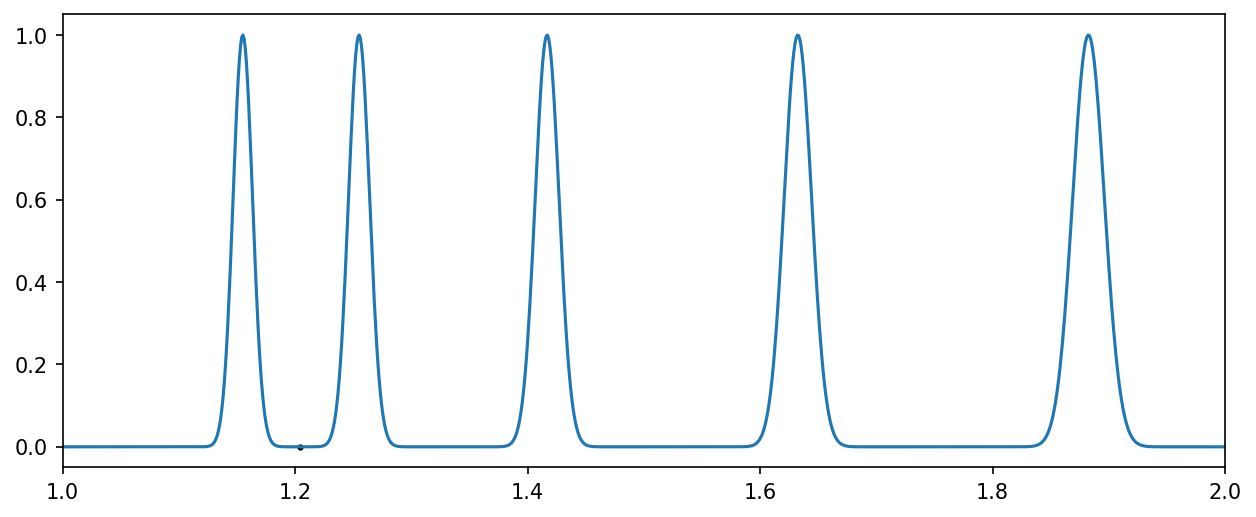

C:\Users\Antoine\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Antoine\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Antoine\anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 10000 is greater than input length  = 9501, using nperseg = 9501
  warnings.warn('nperseg = {0:d} is greater than input length '


(5, 51)


C:\Users\Antoine\github\biotuner\biotuner.py:146: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  harm_fit = np.array(harm_temp).squeeze()


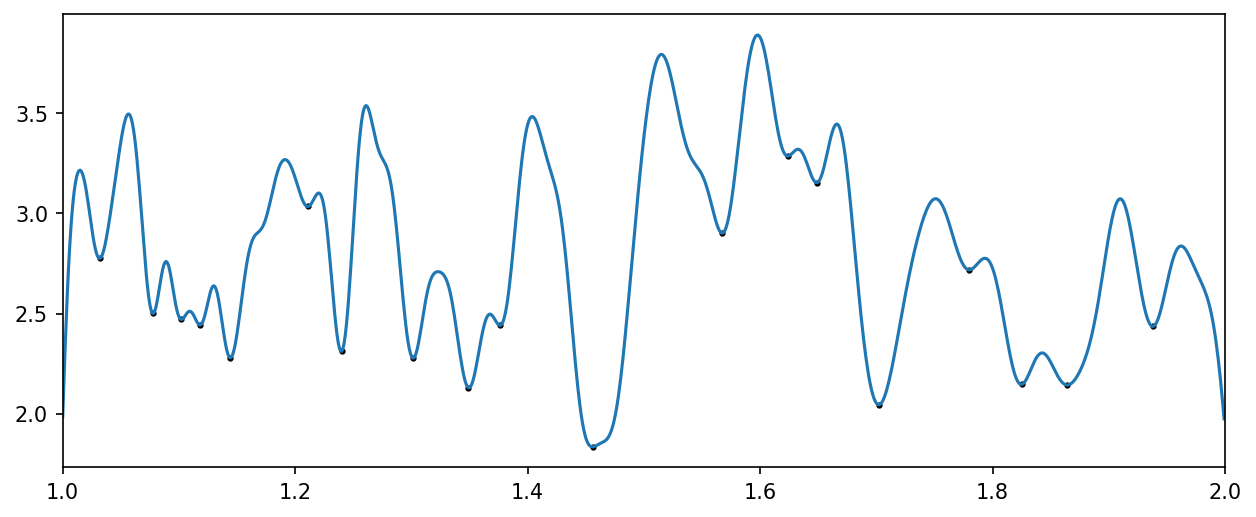

In [34]:
harms = [10,50]
data = epochs_data[47][28] # Define data (single time series)
for i in harms:
    biotuning = biotuner(1000, peaks_function = 'EEMD', precision = 0.1, n_harm = i)
    biotuning.peaks_extraction(data)
    biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult', cons_limit = 0.1)
    biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', plot_entropy = True)

In [ ]:
biotuning.extended_peaks

In [ ]:
a, b, c = oct_subdiv(3/2,0.01367,2,10)
m = compare_oct_div(Octdiv = 53, Octdiv2 = 12, bounds = 0.003, octave = 2)
m

In [ ]:
#a, b = multi_oct_subdiv (biotuning.peaks, 200, 0.01)
a

In [ ]:
def multi_oct_subdiv (peaks, max_sub, octave_limit, octave = 2, n_scales = 10):
    import itertools
    from collections import Counter
    a, b, pairs, cons = consonance_peaks(peaks, 0.01)
    ratios, cons = consonant_ratios(peaks, 0.01)
    print(ratios)
    list_oct_div = []
    for i in range(len(ratios)):
        list_temp, no= oct_subdiv(ratios[i], octave_limit, octave, n_scales)
        print(list_temp)
        list_oct_div.append(list_temp)


    counts = Counter(list(itertools.chain(*list_oct_div)))
    oct_div_temp = []
    for k, v in counts.items():
        if v > 1:
            oct_div_temp.append(k)
    oct_div_temp = np.sort(oct_div_temp)
    oct_div_final = []
    for i in range(len(oct_div_temp)):
        if oct_div_temp[i] < max_sub:
            oct_div_final.append(oct_div_temp[i])
    return oct_div_final, ratios

In [ ]:
biotuning.HE_scale

In [ ]:
biotuning = biotuner(1000, peaks_function = 'adapt', precision = 0.1, n_harm = 30)
biotuning = biotuning.fit_all(data)
biotuning.peaks_ratios

In [42]:
vars(biotuning)
#biotuning.HE_scale

{'sf': 1000,
 'peaks_function': 'EEMD',
 'precision': 0.5,
 'compute_sub_ratios': False,
 'n_harm': 30,
 'harm_function': 'mult',
 'extension_method': 'consonant_harmonic_fit',
 'scale_metrics': {'diss_euler': 'NaN',
  'dissonance': 0.5563247933637208,
  'diss_harm_sim': 2.7095492085820907,
  'diss_n_steps': 4,
  'HE': 4.368746383564832,
  'HE_n_steps': 20,
  'HE_harm_sim': 0.8255924915734498},
 'data': array([-8.64243264e-06, -9.80262201e-06, -1.13185112e-05, ...,
        -6.60467652e-06, -6.28905229e-06, -6.97932280e-06]),
 'IMFs': array([[-0.00290447,  0.00115101,  0.00417498, ..., -0.02524407,
         -0.02620837, -0.01872021],
        [-0.07121908, -0.07715492, -0.08296818, ..., -0.04218764,
         -0.05707478, -0.06637483],
        [ 0.00494203,  0.00552644,  0.00607695, ...,  0.03310178,
          0.03016469,  0.02689641],
        [ 0.01562509,  0.0164571 ,  0.01721778, ..., -0.16583925,
         -0.16447179, -0.16280333],
        [ 0.05979235,  0.05995648,  0.06007608, ..., 